# Initializations

> Weights should be initialized apropriately

Adapted from:

- [https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s](https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s)

In [1]:
#| default_exp initializations

In [2]:
# |export
import math
import random
from contextlib import contextmanager
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import Tensor, nn
from torch.nn import init
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import Conv2dWithReLU, StoreModuleStatsCB, set_seed
from slowai.datasets import get_grid, show_image
from slowai.learner import (
    Callback,
    DeviceCB,
    LRFinderCB,
    MetricsCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
    to_cpu,
)

In [3]:
set_seed(42)
plt.style.use("ggplot")

## Probability, Miscellaneous

- "Average error" is typically 0 because positive and negative errors cancel out, making this metric not useful. We can avoid this by using the "{Root, }Mean Squared Error," which counts large errors more strongly
- **Variance**

> In probability theory and statistics, variance is the expected value of the squared deviation from the mean of a random variable

[https://en.wikipedia.org/wiki/Variance](https://en.wikipedia.org/wiki/Variance)

$$\sigma^2 = \sum \frac{(x-\mathbb{E}[X])^2}{N}$$

  This version is quicker to calculate:

$$\sigma^2 = \mathbb{E}[X^2] - \mathbb{E}[X]^2$$

- **Convariance**

> Covariance in probability theory and statistics is a measure of the joint variability of two random variables.

[https://en.wikipedia.org/wiki/Covariance](https://en.wikipedia.org/wiki/Covariance)

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

You can think about this as the average product of residuals of different features. If two features "co-vary," these products will be very large or very small; if not, they the products will be totally random and the sum will be small (because different directions cancel eachother out).

- **Pearson correlation coefficient**

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

Think of this as a __normalized covariance__. 

## Baseline

Let's look at a fashion MNIST classification problem. Our goal is to get accuracy to at least 90%.

In [4]:
class CNN(nn.Module):
    """Six layer convolutional neural network"""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv2dWithReLU(1, 8, kernel_size=5, stride=2, padding=2),  # 14x14
            Conv2dWithReLU(8, 16, kernel_size=3, stride=2, padding=1),  # 7x7
            Conv2dWithReLU(16, 32, kernel_size=3, stride=2, padding=1),  # 4x4
            Conv2dWithReLU(32, 64, kernel_size=3, stride=2, padding=1),  # 2x2
            nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),  # 1x1
        )

    def forward(self, x):
        x = self.layers(x)
        return rearrange(x, "bs c w h -> bs (c w h)")

Let's start by finding the learning rate.

This diverges very quickly

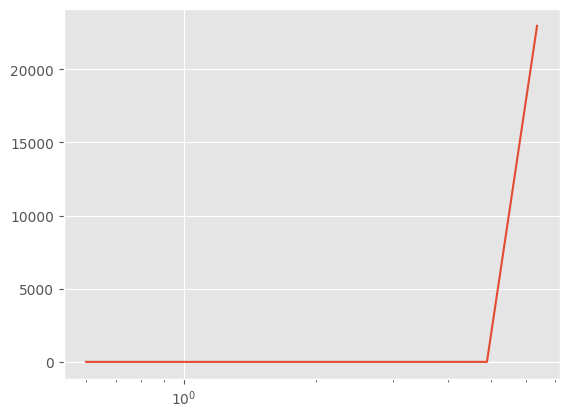

In [5]:
learn = TrainLearner(
    CNN(),
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=[LRFinderCB()],
).fit()

That's unusable. Let's dial down the learning rate increase and start at a lower learning rate.

In [6]:
LRFinderCB?

Init signature: LRFinderCB(gamma=1.3, max_mult=3)
Docstring:     
Find an apopriate learning rate by increasing it by a constant factor for each batch
until the loss diverges
File:           ~/Desktop/SlowAI/nbs/slowai/learner.py
Type:           type
Subclasses:     

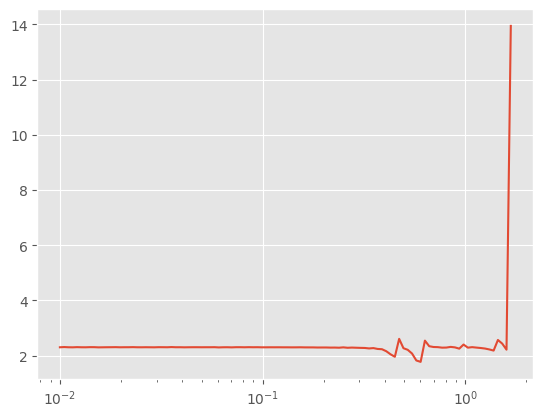

In [7]:
learn = TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05)],
).fit()

MulticlassAccuracy,loss,epoch,train
0.168,2.375,0,train
0.100,2.301,0,eval


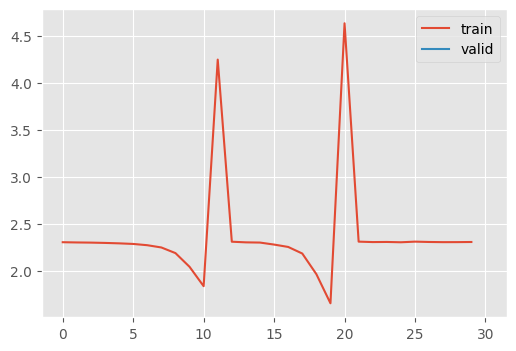

In [ ]:
model = CNN()
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    stats,
]
learn = TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=cbs,
).fit(2)

In [ ]:
stats.hist_plot()

The issue with neural networks in real life is that they must be represented by discrete data structures. These can overflow...

In [ ]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5, 0:5]

...or underflow..

In [ ]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100) * 0.01
x[0:5, 0:5]

We should scale our weights such that, throughout the training process, the mean remains near 0 and the standard deviation remains near 1. Otherwise, we are suseptible to these "dead units"

## Glorot/Xavier

Normally, the mean variance of a layer is approximately the number of output dimensions

In [ ]:
for d in [1, 100]:
    means = []
    sqrs = []

    for _ in range(500):
        x = torch.randn(d)
        a = torch.randn(512, d)
        y = a @ x
        means.append(y.mean())
        sqrs.append(y.pow(2).mean())

    res = torch.stack(means).mean(), torch.stack(sqrs).mean()
    print(res)



To encourage of variance of 1, the paper from Xavier Glorot and Yoshua Bengio proposed that each layer have a coefficient of $\frac{1}{\sqrt{d}}$ where $d$ is the number of inputs

In [ ]:
d = 100
x = torch.randn(200, d)
for i in range(50):
    layer = torch.randn(d, d) * (1 / math.sqrt(d))
    x = x @ layer
x[0:5, 0:5]

Indeed, this gives us reasonable numbers! However, this doesn't work for modern deep learning because of the **activation layers**.


## Kaiming/He init

Notice that the first layer of a neural network has a favorable activation distribution

In [ ]:
d1, d2 = 100, 100
x = torch.randn(200, d1)
y = torch.randn(200)
w = torch.randn(d1, d2) / math.sqrt(d1)
b = torch.zeros(d2)

In [ ]:
l1 = x @ w + b
l1.mean(), l1.std()

But what happens when we add non-linearities?

In [ ]:
def relu(x):
    return x.clamp_min(0.0)


l1r = relu(l1)
l1r.mean(), l1r.std()

Indeed, this property is lost...thus lies the path to perdition...

In [ ]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(1 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

To rectify this situation, Kaiming proposed using $\sqrt{\frac{2}{d}}$ 😂

In [ ]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(2 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

Notice, there are still positive numbers even after 50 layers!

This is the best way to initialize a network. But how do we do this on a code level? We use the `.apply()` method.

In [ ]:
def init_weights(module):
    # `kaiming_normal_` is an in-place operation, unlike `kaiming_normal`
    if not isinstance(module, (nn.Sequential, Conv2dWithReLU, CNN)):
        init.kaiming_normal_(module.weight)

In [ ]:
model = CNN()
model.apply(init_weights)
learn = TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05)],
).fit()

Better! Let's try training with 0.25.

In [ ]:
model = CNN()
model.apply(init_weights)
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    stats,
]
learn = TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
).fit(2)

In [ ]:
stats.mean_std_plot()

That's okay. Keep in mind, I didn't include momentum, like Jeremy; but I did globally normalize the inputs.

In [ ]:
fash

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()